<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Learning_the_Optimal_Solution_Path_vs_Naive_Grid_Search_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [5]:
!wget -O helpers.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py

import helpers

--2023-12-11 03:20:44--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2345 (2.3K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]   2.29K  --.-KB/s    in 0s      

2023-12-11 03:20:44 (39.7 MB/s) - ‘helpers.py’ saved [2345/2345]



In [6]:
!wget -O NGS.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py

import NGS

--2023-12-11 03:20:44--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9434 (9.2K) [text/plain]
Saving to: ‘NGS.py’

NGS.py              100%[===================>]   9.21K  --.-KB/s    in 0s      

2023-12-11 03:20:44 (109 MB/s) - ‘NGS.py’ saved [9434/9434]

Using device: cuda


In [7]:
!wget -O SGD.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py

import SGD

--2023-12-11 03:20:44--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4938 (4.8K) [text/plain]
Saving to: ‘SGD.py’

SGD.py              100%[===================>]   4.82K  --.-KB/s    in 0s      

2023-12-11 03:20:45 (70.2 MB/s) - ‘SGD.py’ saved [4938/4938]



# Preliminaries

## Dataset
We use the Wisconsin breast cancer dataset and then port it over an object of the Pytorch dataset class so it can be read by data_loader.

Description of the breast cancer Wisconsin dataset (classification): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [8]:
from sklearn.datasets import load_breast_cancer

In [9]:
# load breast cancer data
X, y = load_breast_cancer(return_X_y=True)

In [10]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [11]:
clf = LogisticRegression(solver='lbfgs', max_iter=100).fit(X[:100,:], y[:100])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
clf.predict(X[:100,:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [13]:
# preprocess data
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


## Tuning the Learning Rate for Naive Grid Search

To gauge the performance of our model, we set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model on each grid.

Use the first 100 datapoints to select the best constant learning rate for Naive Grid Search. Make several plots of sup error along the solution path against learning rate using 500 iterations.

In [ ]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-2, 11)
epochs = 500
input_dim = X.shape[1]
lam = 0.5
init_weight = torch.zeros(input_dim)
criterion = torch.nn.BCELoss()

In [ ]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
losses = []
for lr in lr_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        NGS.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = NGS.test(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 0.1987709105014801
learning rate: 0.125	 loss: 0.1987709403038025
learning rate: 0.0625	 loss: 0.1987709254026413
learning rate: 0.03125	 loss: 0.1987709403038025
learning rate: 0.015625	 loss: 0.1987711638212204
learning rate: 0.0078125	 loss: 0.19881215691566467
learning rate: 0.00390625	 loss: 0.1999007761478424
learning rate: 0.001953125	 loss: 0.207317516207695
learning rate: 0.0009765625	 loss: 0.22796867787837982
learning rate: 0.00048828125	 loss: 0.2595781087875366
learning rate: 0.000244140625	 loss: 0.29128414392471313


From the plot, we see that learning rate = $2^{-4}$ gives a low loss stably.

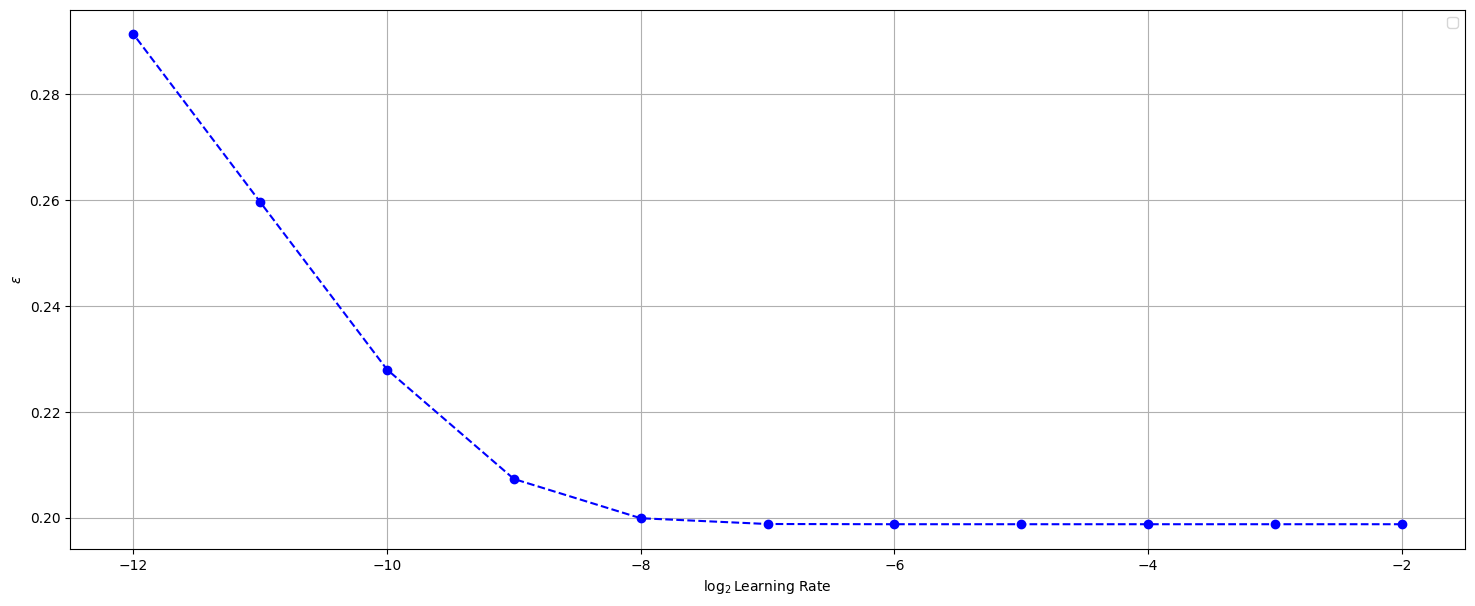

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
losses = []
for alpha in alpha_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        NGS.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = NGS.test(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.1987709254026413
alpha: 2.0	 loss: 0.19877101480960846
alpha: 1.0	 loss: 0.1987801343202591
alpha: 0.5	 loss: 0.19901572167873383
alpha: 0.25	 loss: 0.20121613144874573
alpha: 0.125	 loss: 0.21042440831661224
alpha: 0.0625	 loss: 0.23303022980690002
alpha: 0.03125	 loss: 0.2659202516078949
alpha: 0.015625	 loss: 0.2966602146625519
alpha: 0.0078125	 loss: 0.3185037672519684
alpha: 0.00390625	 loss: 0.3316492736339569
alpha: 0.001953125	 loss: 0.33887380361557007
alpha: 0.0009765625	 loss: 0.3426622748374939


From the plot, we see that $\alpha = 2$ gives a low loss stably.

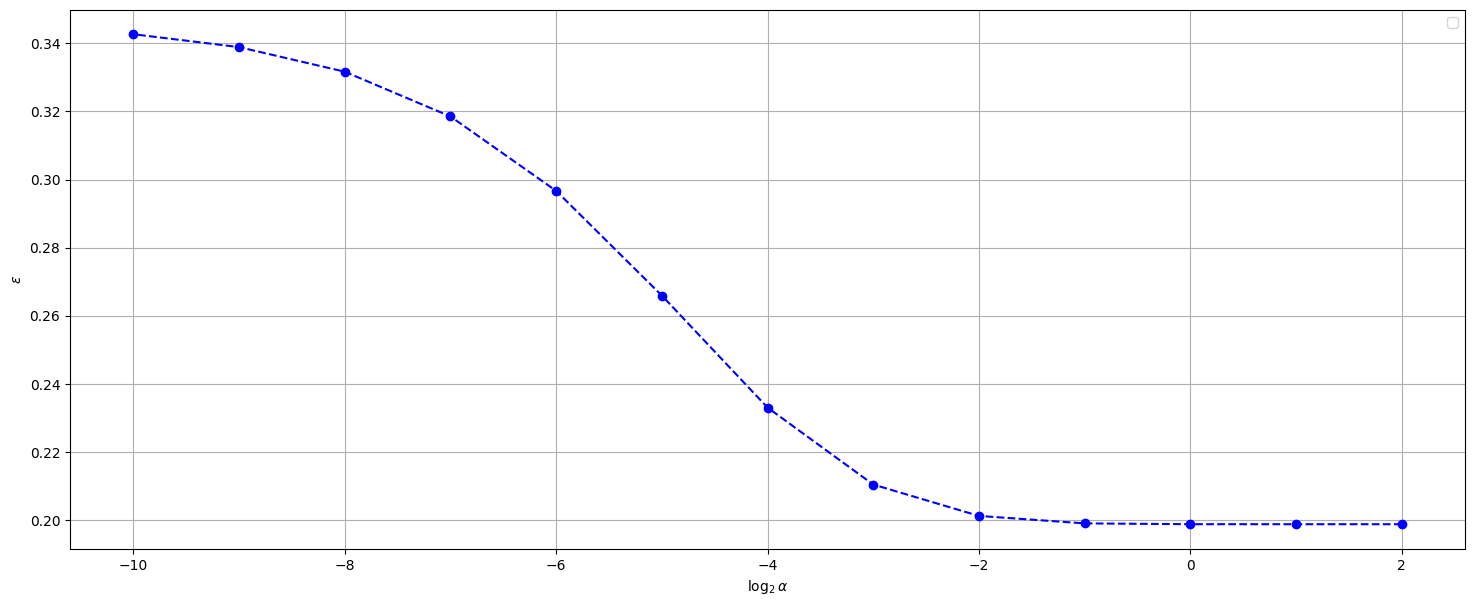

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), losses, '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

## The True Solution Path

We use the Naive Grid Search with $2^{10}$ grids, trained by full gradient descent with learning rate = $2^{-4}$ and 5000 iterations on each grid, to generate a true solution path.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [17]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [18]:
num_grid = 2**10
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)

In [19]:
# epochs = 5000
# lr = 0.5**4

In [20]:
# models, num_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
#                                     num_grid=num_grid, epochs=epochs, loss_fn=criterion,
#                                     trainDataLoader=GD_data_loader,
#                                     data_input_dim=input_dim,
#                                     lr=lr, SGD=False)

In [21]:
# losses = []
# for model in models:
#     losses.append(NGS.test(test_data_loader, model, criterion, model.reg_param))

In [22]:
# thetas = []
# for model in models:
#     thetas.append(model.linear.weight.data.cpu().detach().numpy()[0])
# thetas = np.array(thetas)
# print(thetas.shape)

In [23]:
# intercepts = []
# for model in models:
#     intercepts.append(model.linear.bias.data.cpu().detach().numpy()[0])
# intercepts = np.array(intercepts)
# print(intercepts.shape)

In [24]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/exact_soln_list.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['losses', 'theta_0', 'theta_1', 'theta_2', 'theta_3',
#                          'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8',
#                          'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
#                          'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18',
#                          'theta_19', 'theta_20', 'theta_21', 'theta_22', 'theta_23',
#                          'theta_24', 'theta_25', 'theta_26', 'theta_27', 'theta_28',
#                          'theta_29', 'theta_30'])

#     # Write the data from your lists
#     for i in range(num_grid):
#         csv_writer.writerow([losses[i], intercepts[i], thetas[i][0], thetas[i][1],
#                              thetas[i][2], thetas[i][3], thetas[i][4], thetas[i][5],
#                              thetas[i][6], thetas[i][7], thetas[i][8], thetas[i][9],
#                              thetas[i][10], thetas[i][11], thetas[i][12], thetas[i][13],
#                              thetas[i][14], thetas[i][15], thetas[i][16], thetas[i][17],
#                              thetas[i][18], thetas[i][19], thetas[i][20], thetas[i][21],
#                              thetas[i][22], thetas[i][23], thetas[i][24], thetas[i][25],
#                              thetas[i][26], thetas[i][27], thetas[i][28], thetas[i][29]])

In [25]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/exact_soln_list.csv'
truth = pd.read_csv(csv_file_path)
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

#Learning the Solution Path Through SGD
Now, let us try running SGD over $Δλ$'s on a linear basis $\Phi(\lambda)$ of our choice. We now want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function becomes $h(\theta, \lambda) = (1-\lambda) BCE(X\Phi(\lambda)\beta,\ y) + \frac{\lambda}{2}\|\Phi(\lambda)\beta\|^2$. For each batch of training data set, we randomize $\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

## Our Model

We use Legendre polynomials with degree $\leq 9$ as the basis vectors for $\Phi(\lambda)$.

In [26]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [27]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [28]:
phi_lam = SGD.phi_lam_Legendre

In [29]:
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

## Tuning the learning rate for our model

In [19]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-2, 9)
epochs = 500
lam = 0.5
criterion = torch.nn.BCELoss()

In [20]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 13

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 3.608082318293179e+28
learning rate: 0.125	 loss: 1.2264595031738281
learning rate: 0.0625	 loss: 0.1992998719215393
learning rate: 0.03125	 loss: 0.19877243041992188
learning rate: 0.015625	 loss: 0.1987711489200592
learning rate: 0.0078125	 loss: 0.19877833127975464
learning rate: 0.00390625	 loss: 0.20087231695652008
learning rate: 0.001953125	 loss: 0.20502528548240662
learning rate: 0.0009765625	 loss: 0.22526098787784576
learning rate: 0.00048828125	 loss: 0.25248000025749207
learning rate: 0.000244140625	 loss: 0.287759929895401


From the plot, we see that learning rate = $2^{-6}$ stably gives a low loss for basis dimensions 5, 9, 13.

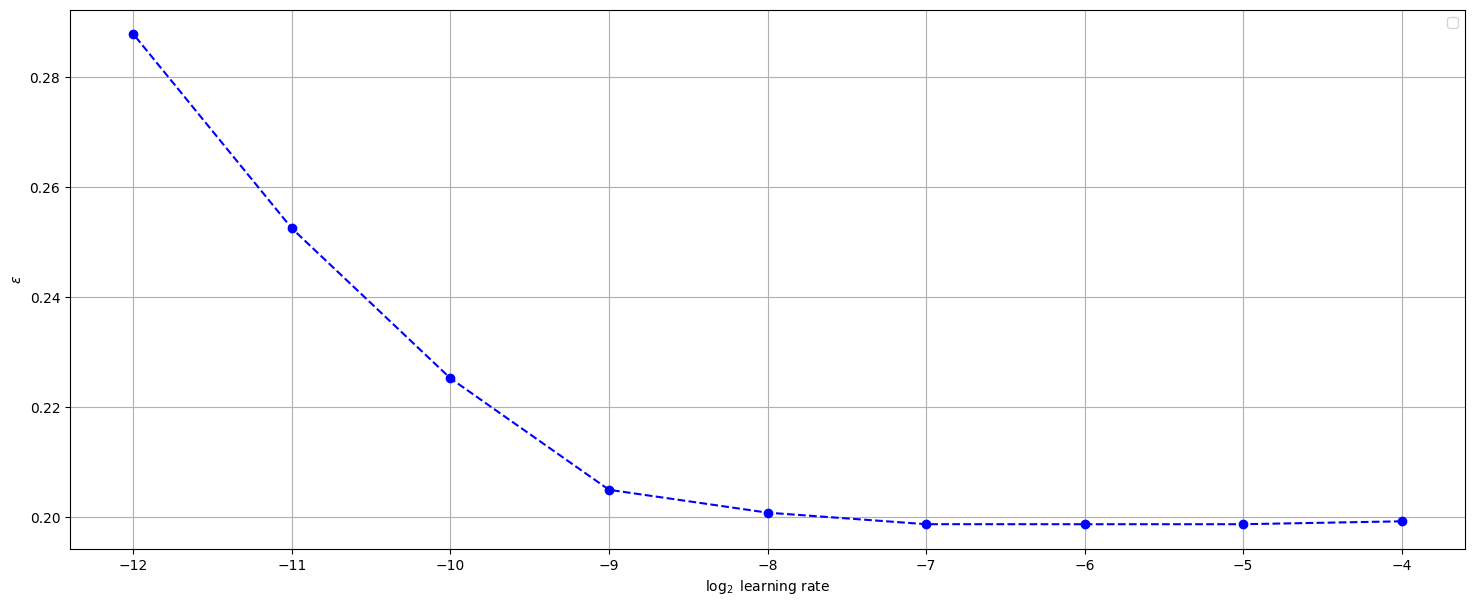

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--bo')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

In [21]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 9

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 2.2424358448975263e+20
learning rate: 0.125	 loss: 3616.119140625
learning rate: 0.0625	 loss: 0.19877517223358154
learning rate: 0.03125	 loss: 0.19877110421657562
learning rate: 0.015625	 loss: 0.198771134018898
learning rate: 0.0078125	 loss: 0.19887469708919525
learning rate: 0.00390625	 loss: 0.19982396066188812
learning rate: 0.001953125	 loss: 0.2086484134197235
learning rate: 0.0009765625	 loss: 0.2280198633670807
learning rate: 0.00048828125	 loss: 0.2593206465244293
learning rate: 0.000244140625	 loss: 0.28788521885871887


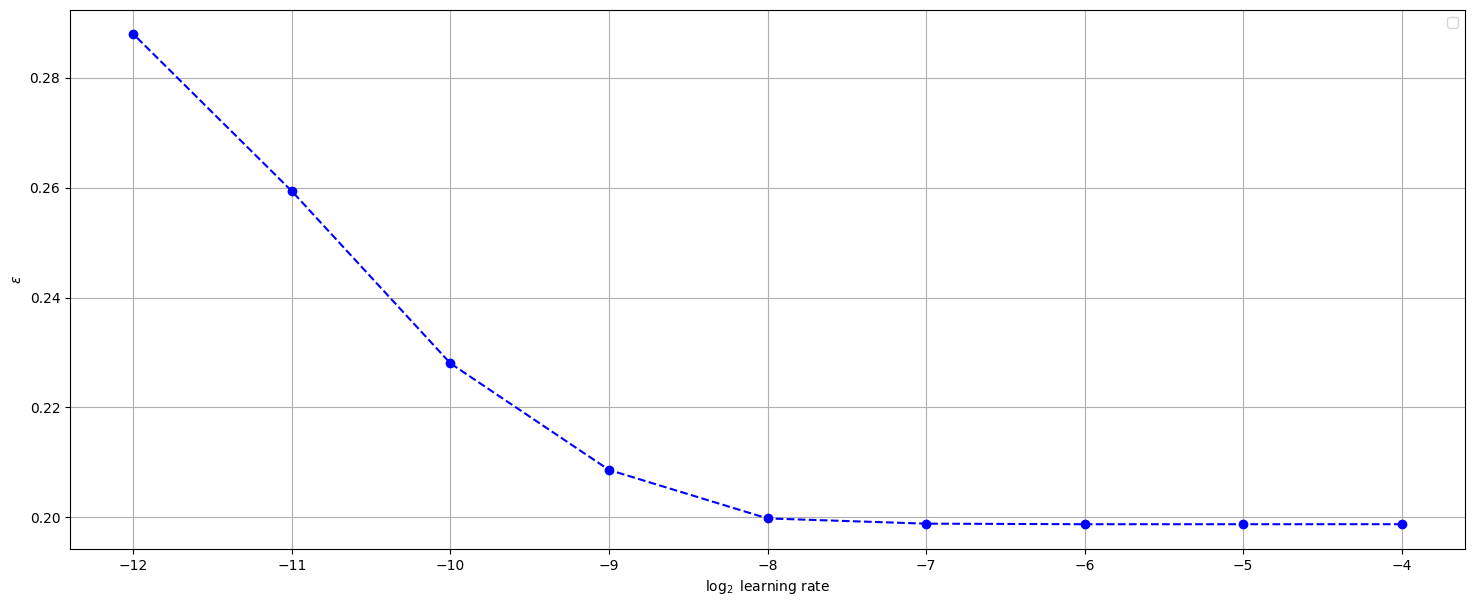

In [22]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--bo')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

In [23]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 0.30737271904945374
learning rate: 0.125	 loss: 0.19877183437347412
learning rate: 0.0625	 loss: 0.19877226650714874
learning rate: 0.03125	 loss: 0.1988091766834259
learning rate: 0.015625	 loss: 0.1987721472978592
learning rate: 0.0078125	 loss: 0.19878734648227692
learning rate: 0.00390625	 loss: 0.2000216394662857
learning rate: 0.001953125	 loss: 0.20598948001861572
learning rate: 0.0009765625	 loss: 0.2297573834657669
learning rate: 0.00048828125	 loss: 0.25836482644081116
learning rate: 0.000244140625	 loss: 0.28918465971946716


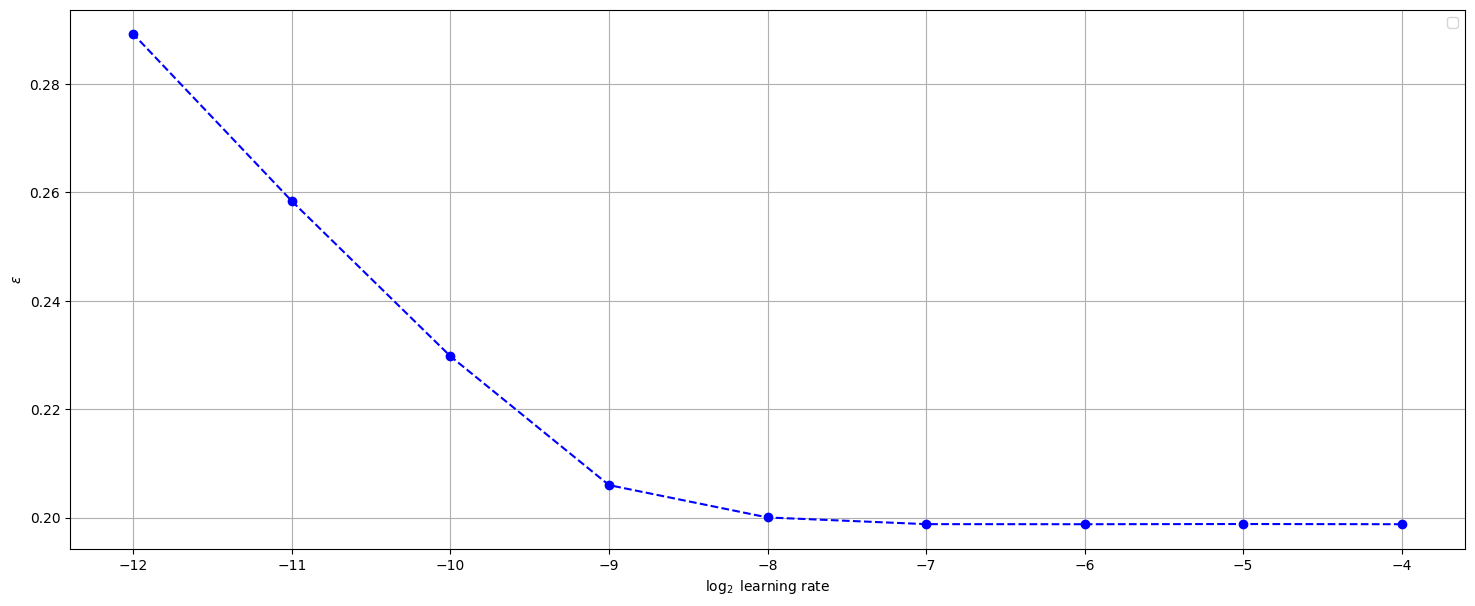

In [24]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--bo')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 13

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.19878239929676056
alpha: 2.0	 loss: 0.19880491495132446
alpha: 1.0	 loss: 0.19895656406879425
alpha: 0.5	 loss: 0.20127013325691223
alpha: 0.25	 loss: 0.21106764674186707
alpha: 0.125	 loss: 0.2348201423883438
alpha: 0.0625	 loss: 0.2426881492137909
alpha: 0.03125	 loss: 0.24519099295139313
alpha: 0.015625	 loss: 0.3084656000137329
alpha: 0.0078125	 loss: 0.3179720938205719
alpha: 0.00390625	 loss: 0.3371119499206543


From the plot, we see that $\alpha = 1$ stably yields low loss for basis dimension 5, 9, 13.



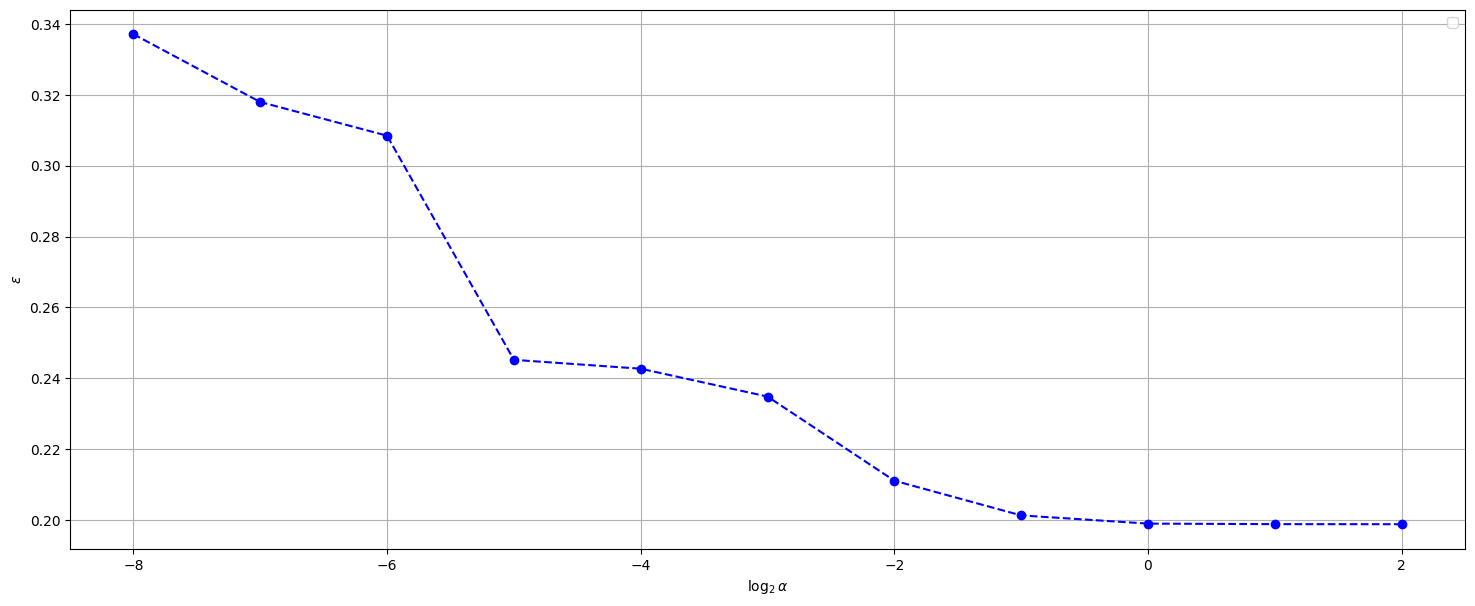

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

In [25]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 9

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.19878190755844116
alpha: 2.0	 loss: 0.19881561398506165
alpha: 1.0	 loss: 0.1991007775068283
alpha: 0.5	 loss: 0.20040355622768402
alpha: 0.25	 loss: 0.20987480878829956
alpha: 0.125	 loss: 0.21904373168945312
alpha: 0.0625	 loss: 0.2519546151161194
alpha: 0.03125	 loss: 0.2640805244445801
alpha: 0.015625	 loss: 0.31489670276641846
alpha: 0.0078125	 loss: 0.3268469274044037
alpha: 0.00390625	 loss: 0.32237738370895386


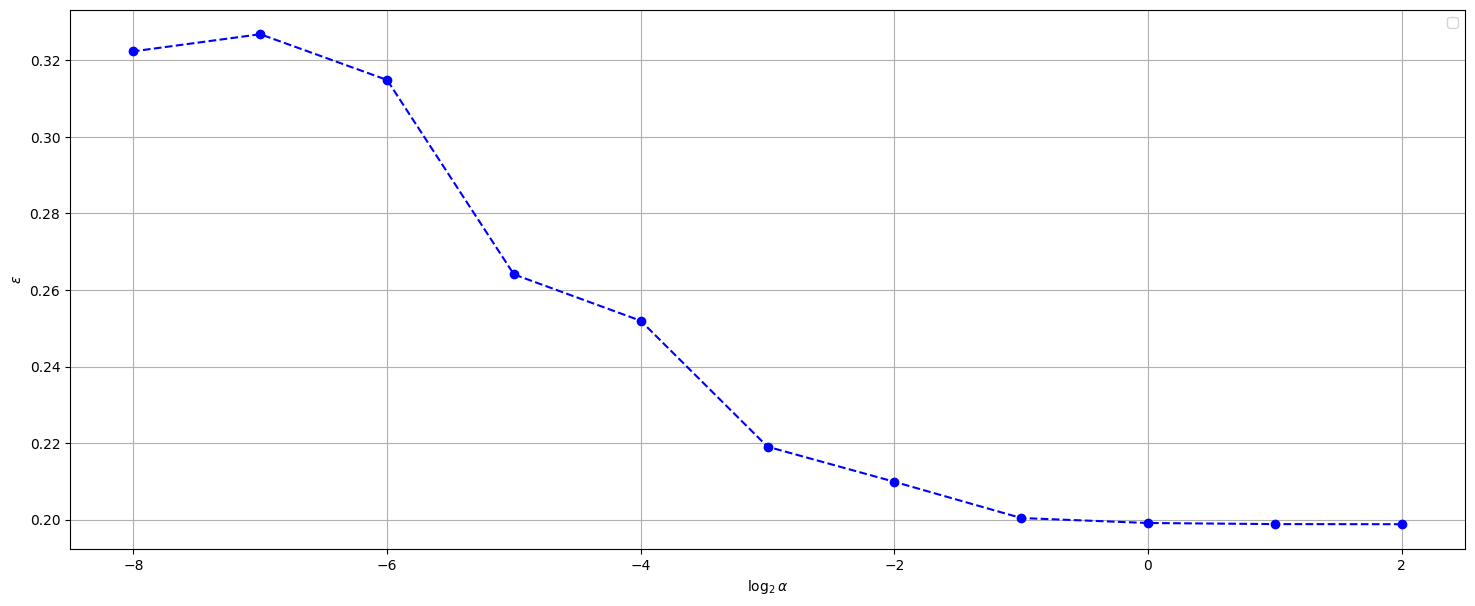

In [26]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

In [27]:
np.random.seed(8675309)
torch.manual_seed(8675309)

basis_dim = 5

losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.19878077507019043
alpha: 2.0	 loss: 0.19880664348602295
alpha: 1.0	 loss: 0.19914931058883667
alpha: 0.5	 loss: 0.20078203082084656
alpha: 0.25	 loss: 0.20544816553592682
alpha: 0.125	 loss: 0.21866357326507568
alpha: 0.0625	 loss: 0.2398146241903305
alpha: 0.03125	 loss: 0.2758011221885681
alpha: 0.015625	 loss: 0.29631295800209045
alpha: 0.0078125	 loss: 0.3218771815299988
alpha: 0.00390625	 loss: 0.3268768787384033


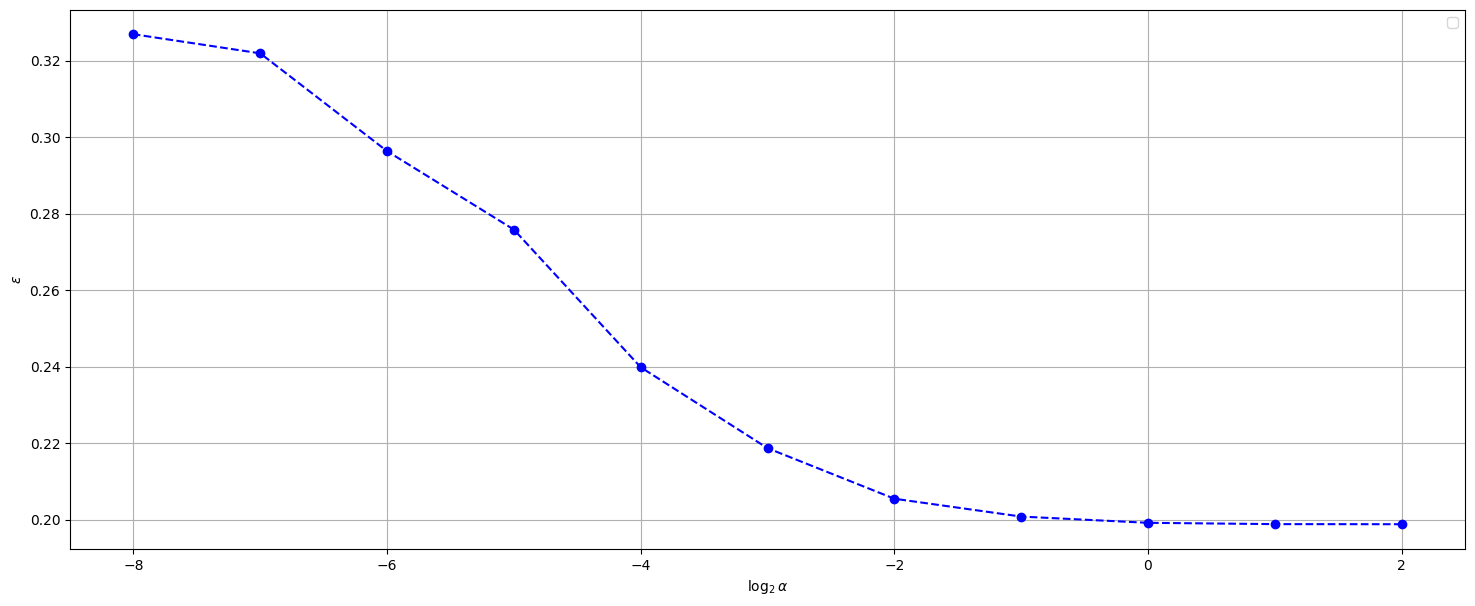

In [28]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

## Visualizing convergence of our model

We use a coefficient profile plot for an arbitrarily selected coefficient (13) to visualize the convergence of our model.

In [ ]:
num_grid = 2**10
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)

In [ ]:
coeff_index = 15

#### Coefficient plot when we use exact gradient.

In [ ]:
# build the model
basis_dim = 13
trace = 500
epoch = trace * (2**3)
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [ ]:
thetas_SGD.shape

(1024, 31)

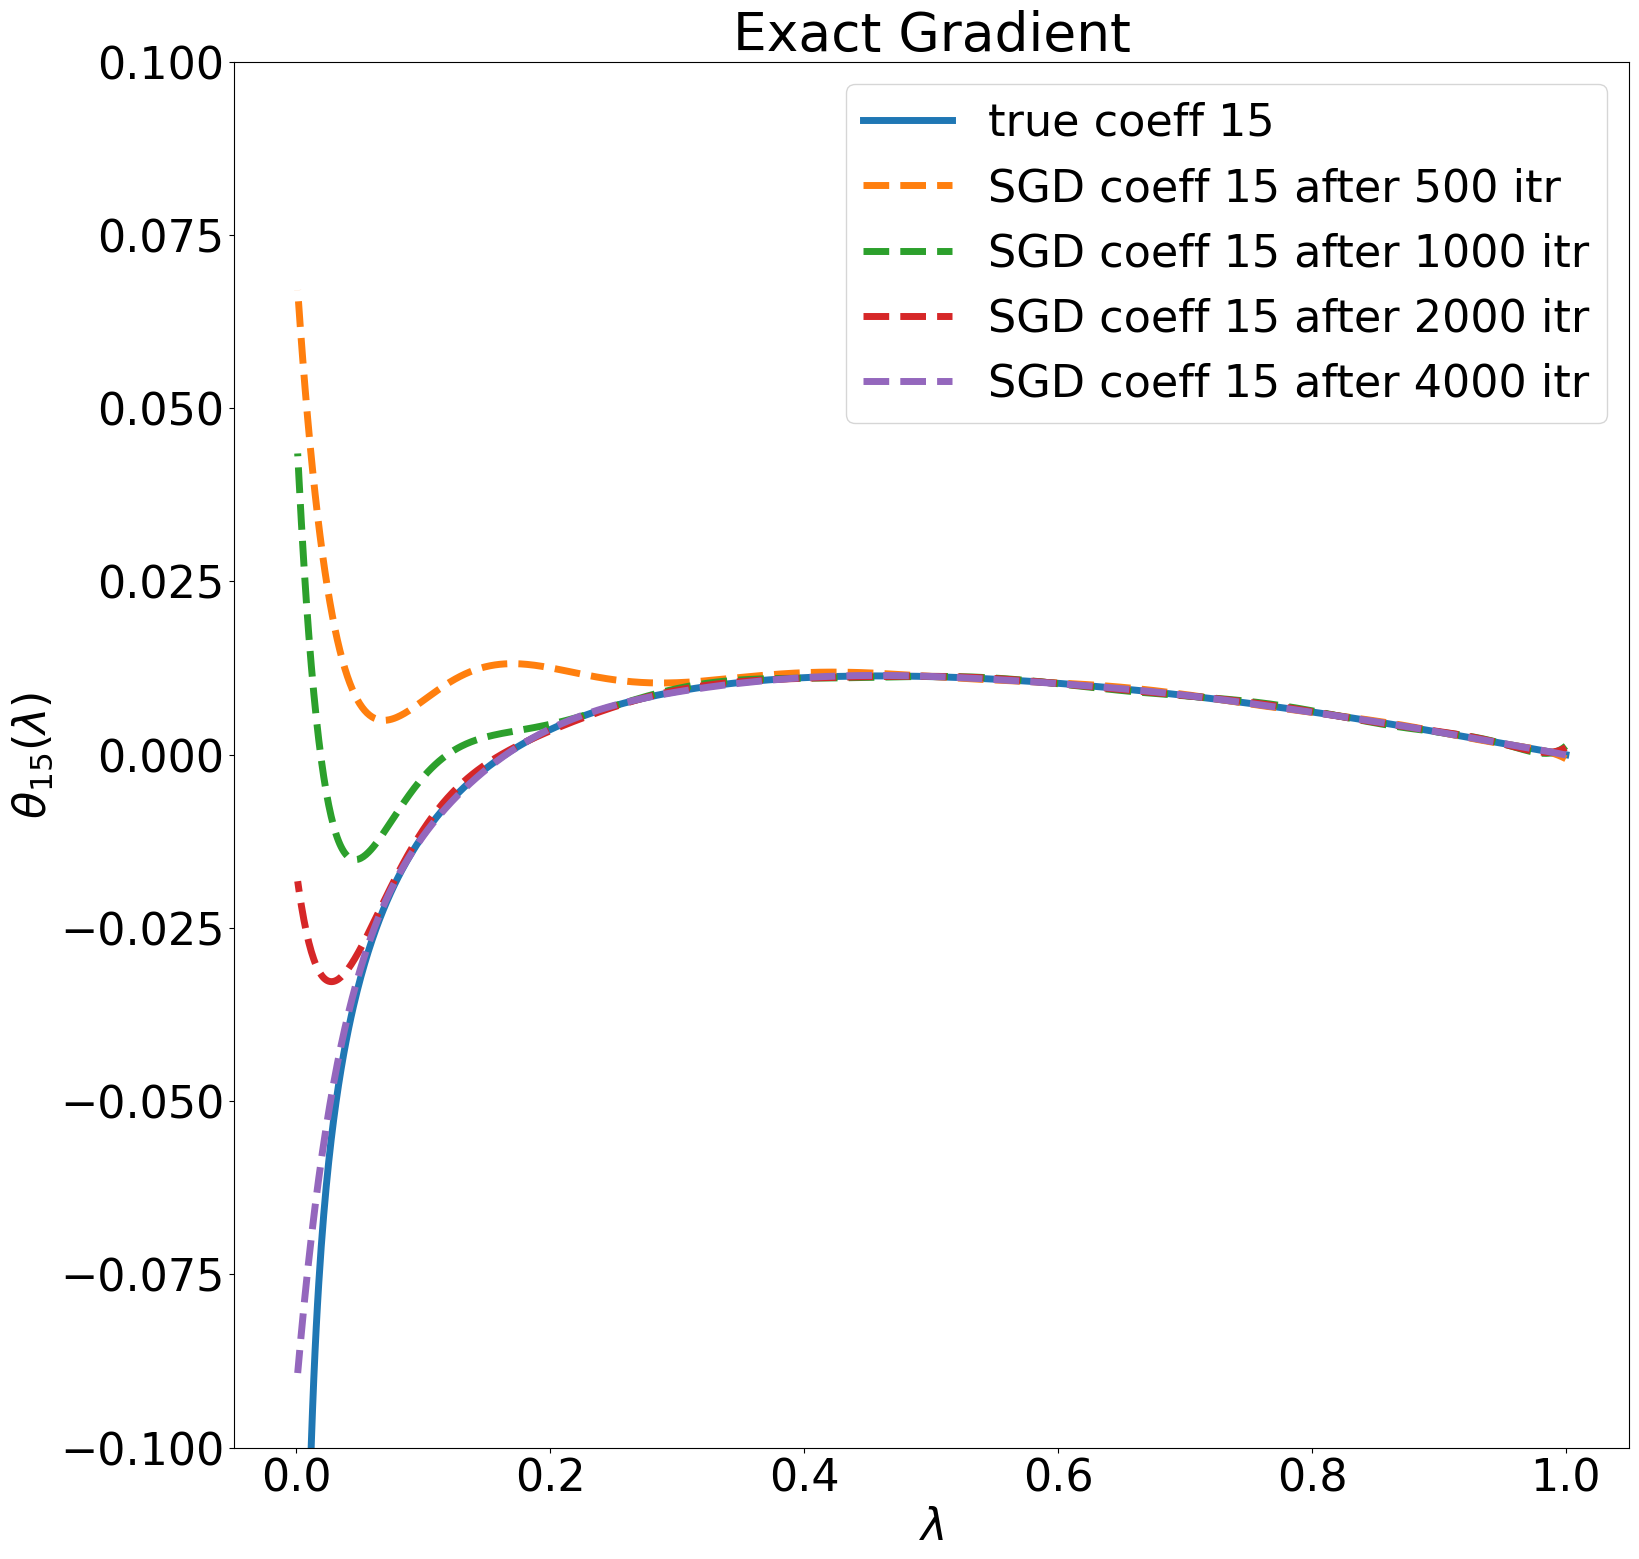

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {500*(2**i)} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('$\\theta_{15}(\\lambda)$')

plt.title('Exact Gradient')

plt.ylim(-0.1, 0.1)
# Add legend
plt.legend()

# Show the plot
plt.show()


### Coefficient profile plot when we use noisy gradient

In [ ]:
# build the model
basis_dim = 13
trace = 200
epoch = trace * (2**3)
alpha = 1

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

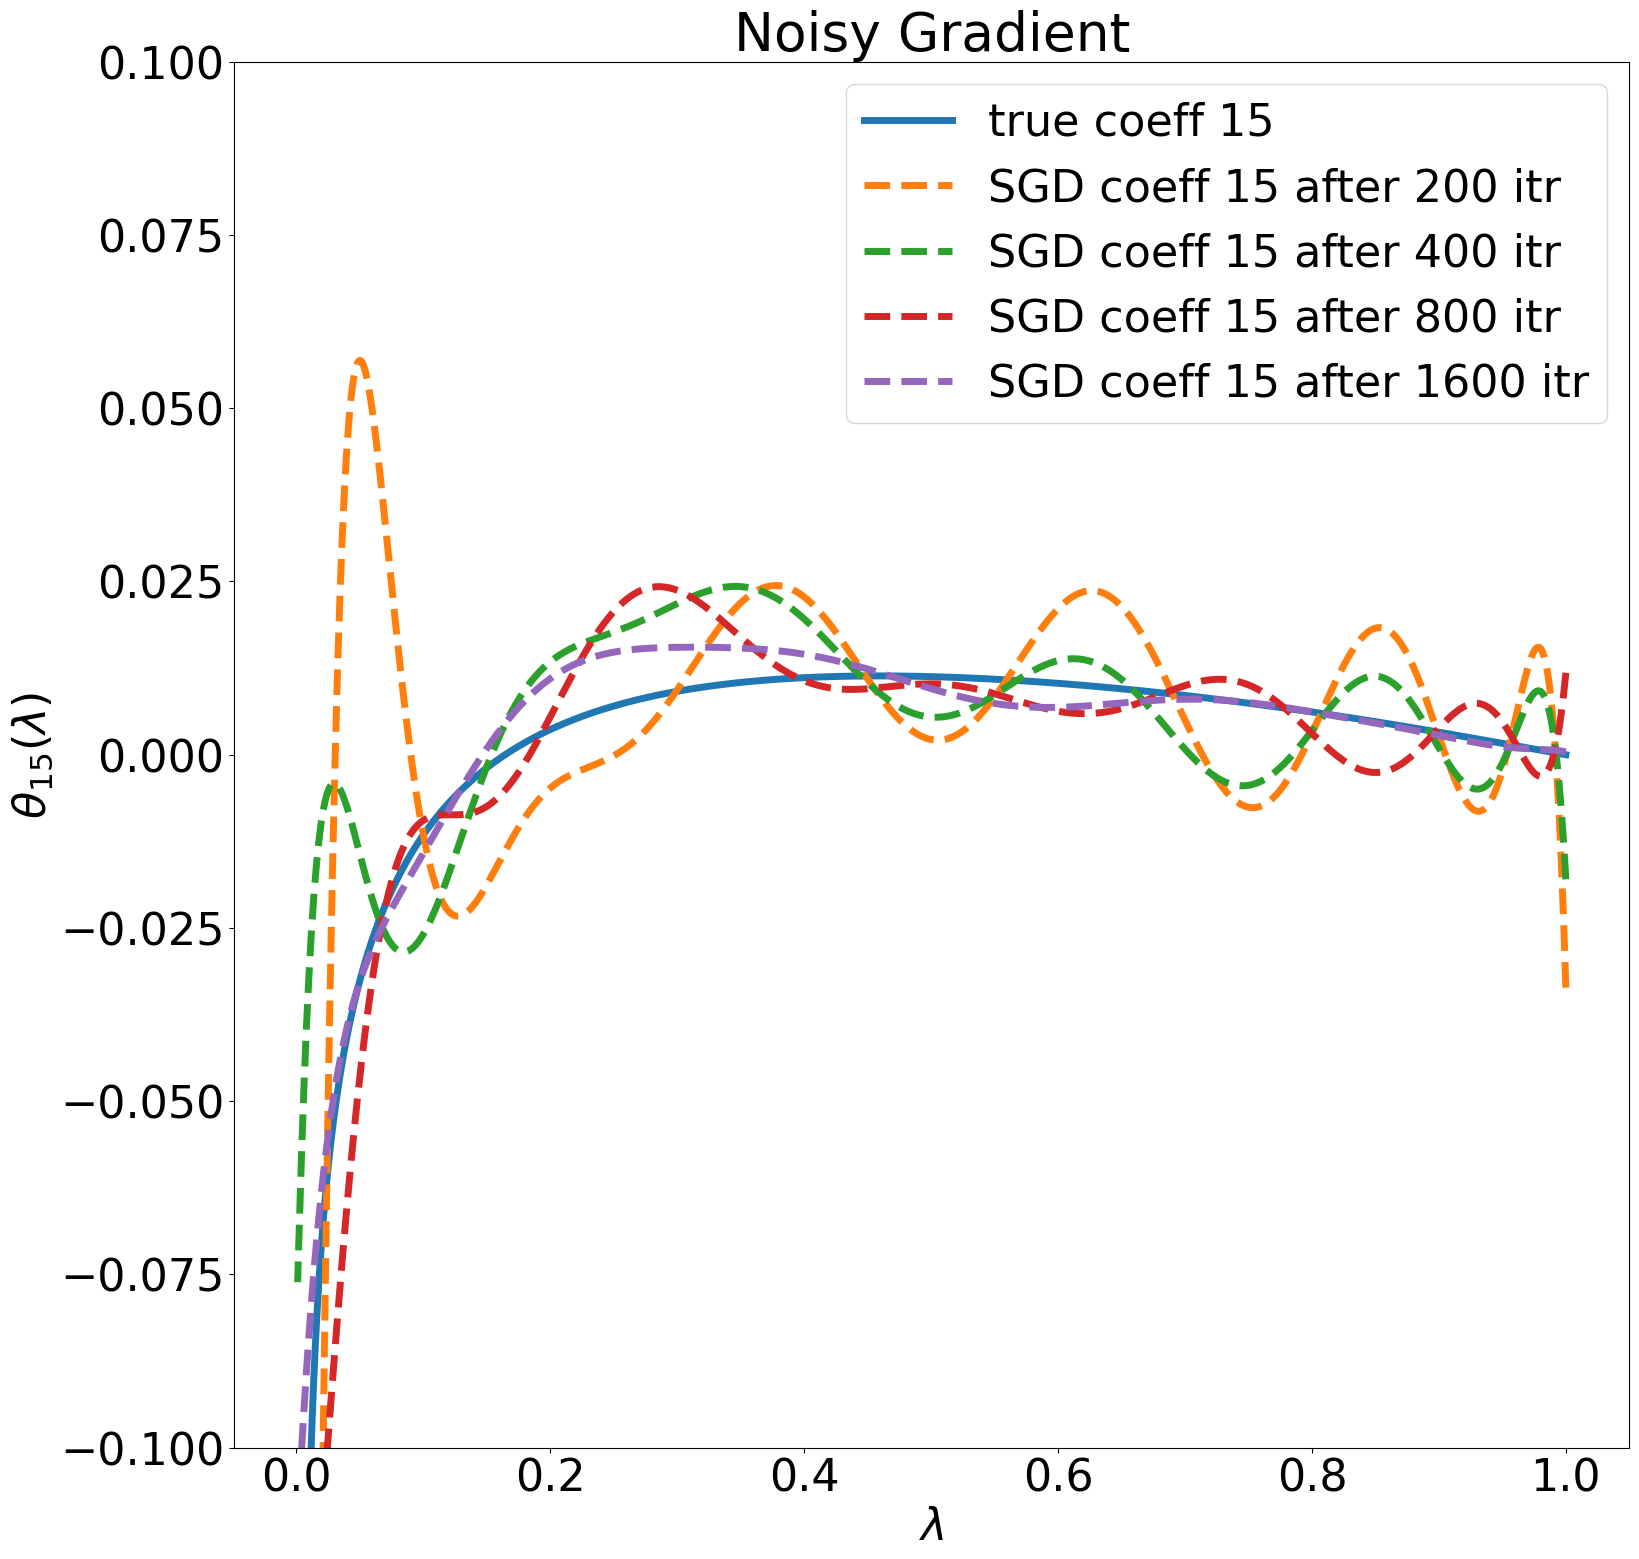

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {200*(2**i)} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('$\\theta_{15}(\\lambda)$')
plt.title('Noisy Gradient')

plt.ylim(-0.1, 0.1)
# Add legend
plt.legend()

# Show the plot
plt.show()


# Compare Learning the Optimal Solution Path with Naive Grid Search

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import time

## First, we run both methods for the exact gradient case.

### Learning the solution path:

Train the SGD model for our method using exact gradient and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned learning rate $2^{-6}$.

In [ ]:
# build the model
basis_dim = 13
epoch = 70000
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.08277498185634619
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.04136178642511373
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.025080904364585925
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.02227828651666646
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.021631643176078845
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.02098102122545247
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.019976474344730426
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.019221559166908313
---------approximate solution path for # epochs = 900 complete------

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err_13'])

#     # Write the data from your lists
#     for i in range(len(epochs)):
#         csv_writer.writerow([epochs[i], sup_err_history[i]])

In [ ]:
for i in range(len(sup_err_history)):
    sup_err_history[i] = np.min(sup_err_history[:i+1])

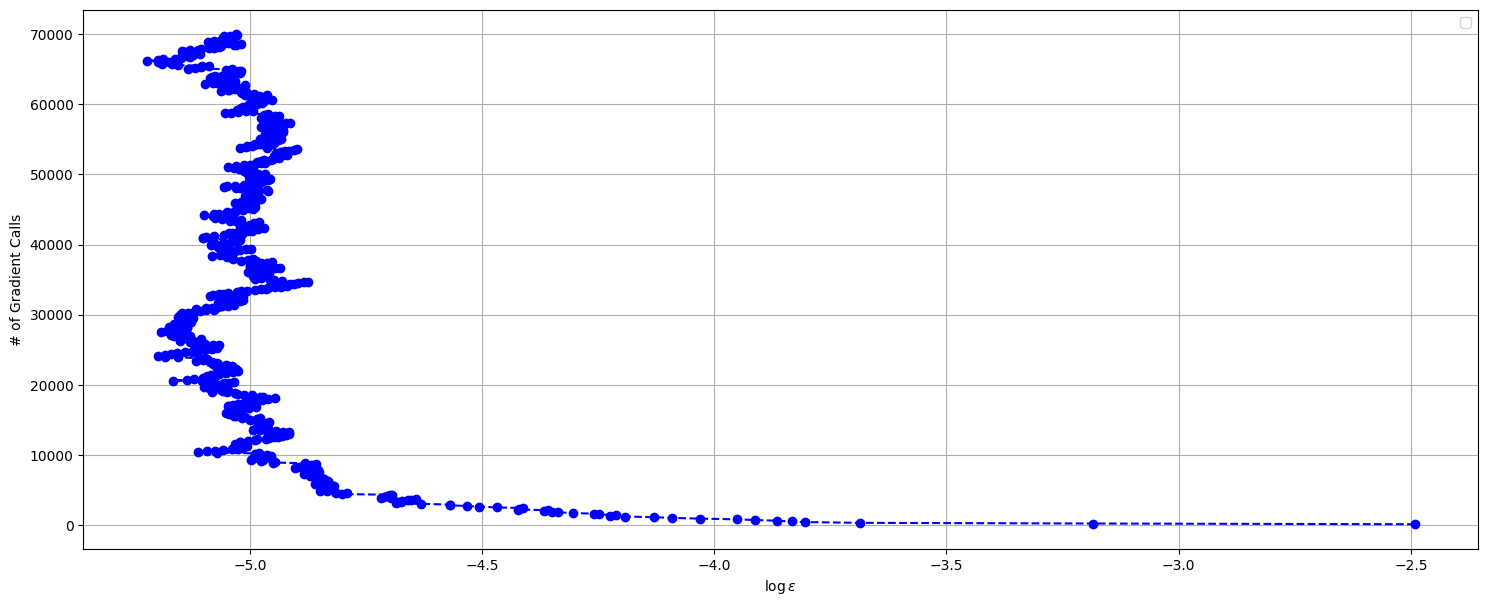

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_err_history)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

In [41]:
# build the model
basis_dim = 9
epoch = 70000
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.3278865516185761
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.10055503249168402
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.06825333833694464
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.04853601753711705
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.03883549571037297
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.036110661923885394
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.03576638549566274
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.03190438449382787
---------approximate solution path for # epochs = 900 complete----------

In [42]:
file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'
df = pd.read_csv(file_path)

# df = df.rename(columns={'sup_err': 'sup_err_13'})

# Add a new column for basis dimension 9
df['sup_err_9'] = sup_err_history

In [43]:
# build the model
basis_dim = 5
epoch = 70000
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.11843346059322363
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.09452392160892492
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.06552653014659887
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.05536081641912465
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.04662087559700017
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.043005697429180194
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.04166424274444585
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.04171338677406316
---------approximate solution path for # epochs = 900 complete---------

In [44]:
# Add a new column for basis dimension 5
df['sup_err_5'] = sup_err_history

# Save the updated DataFrame back to the CSV file
df.to_csv(file_path, index=False)

### Naive Grid Search:

In [31]:
lam_max = 1
lam_min = 0
lr = 0.5**4
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(6, 18, 0.5)
print(delta_list)

tensor([1.5625e-02, 1.1049e-02, 7.8125e-03, 5.5243e-03, 3.9062e-03, 2.7621e-03,
        1.9531e-03, 1.3811e-03, 9.7656e-04, 6.9053e-04, 4.8828e-04, 3.4527e-04,
        2.4414e-04, 1.7263e-04, 1.2207e-04, 8.6317e-05, 6.1035e-05, 4.3158e-05,
        3.0518e-05, 2.1579e-05, 1.5259e-05, 1.0790e-05, 7.6294e-06, 5.3948e-06])


In [32]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))

    start_time = time.time()
    models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=lr, SGD=False, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)
    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)
    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 8.0	 total iteration #: 90	 sup error: 0.14592933654785162	 Execution time: 10.576004981994629 seconds
grid #: 10.0	 total iteration #: 130	 sup error: 0.11772036552429205	 Execution time: 1.2167909145355225 seconds
grid #: 11.0	 total iteration #: 160	 sup error: 0.10536162555217748	 Execution time: 1.1548130512237549 seconds
grid #: 13.0	 total iteration #: 210	 sup error: 0.09239991009235388	 Execution time: 1.6826634407043457 seconds
grid #: 16.0	 total iteration #: 290	 sup error: 0.07800197601318365	 Execution time: 2.4221789836883545 seconds
grid #: 19.0	 total iteration #: 390	 sup error: 0.06834083795547491	 Execution time: 2.974684953689575 seconds
grid #: 23.0	 total iteration #: 550	 sup error: 0.058933906257152606	 Execution time: 4.363746643066406 seconds
grid #: 27.0	 total iteration #: 750	 sup error: 0.051325149834156085	 Execution time: 5.761399745941162 seconds
grid #: 32.0	 total iteration #: 1070	 sup error: 0.04466435313224797	 Execution time: 8.2499470710

In [33]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_exact.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err'])

#     # Write the data from your lists
#     for i in range(len(total_itr_list)):
#         csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

In [ ]:
# for i in range(len(sup_error_list)):
#     sup_error_list[i] = np.min(sup_error_list[:i+1])

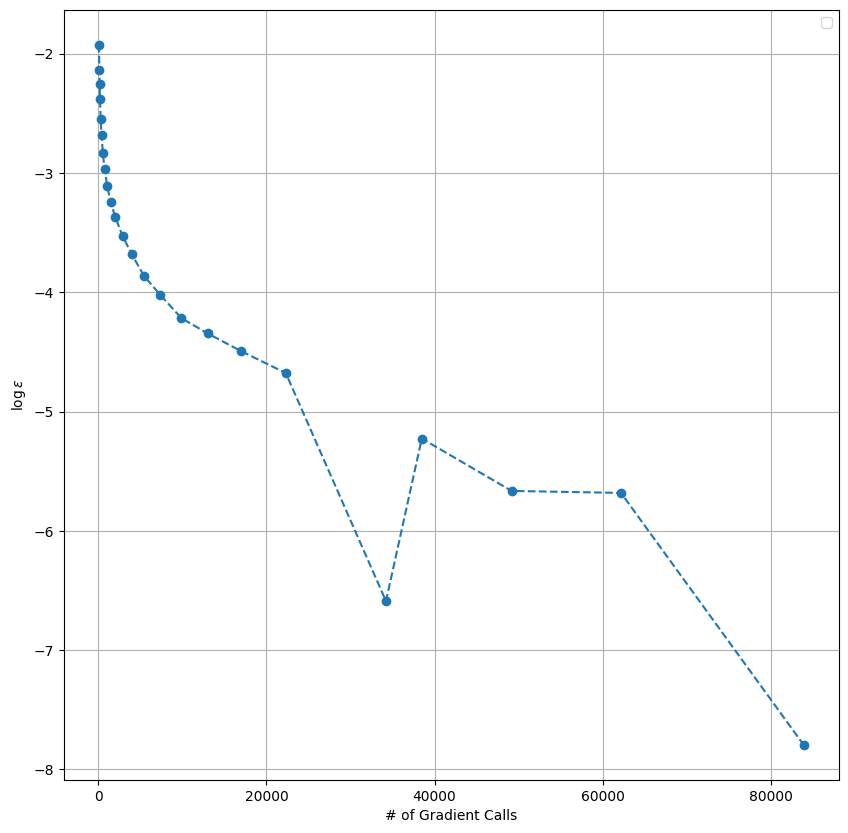

In [45]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_itr_list, np.log(sup_error_list), '--o')
plt.xlabel('# of Gradient Calls')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the exact gradient case

In [46]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_exact.csv'
NGS_results_exact = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_exact['num_itr'])
sup_err_NGS = np.array(NGS_results_exact['sup_err'])

In [47]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_exact.csv'
SGD_results_exact = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_exact['num_itr'])
sup_err_SGD_13 = np.array(SGD_results_exact['sup_err_13'])
sup_err_SGD_9 = np.array(SGD_results_exact['sup_err_9'])
sup_err_SGD_5 = np.array(SGD_results_exact['sup_err_5'])

In [ ]:
# for i in range(len(sup_err_SGD)):
#     sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

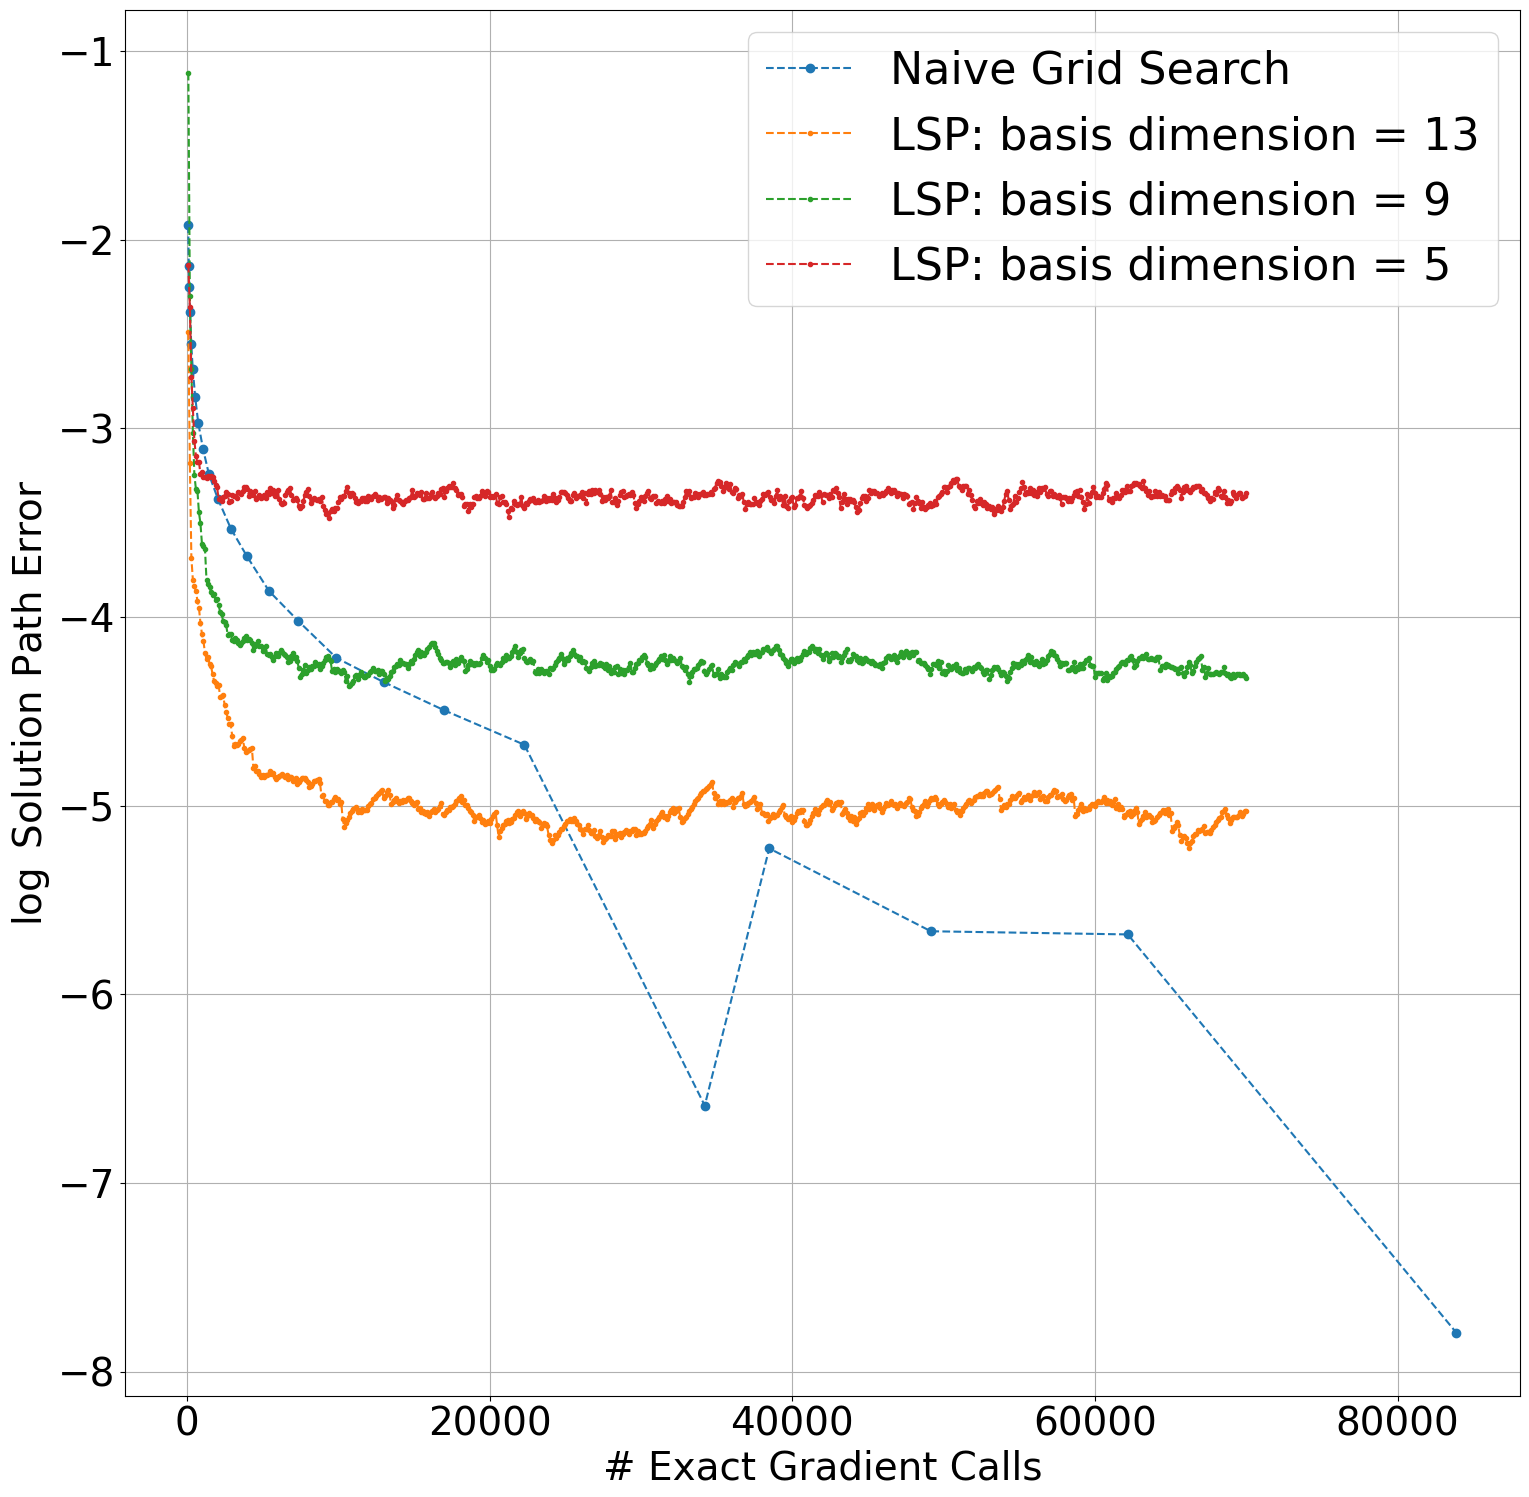

In [48]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(num_itr_NGS, np.log(sup_err_NGS), '--o', label = "Naive Grid Search")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_13), '--.', label = "LSP: basis dimension = 13")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_9), '--.', label = "LSP: basis dimension = 9")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_5), '--.', label = "LSP: basis dimension = 5")

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# Exact Gradient Calls', fontsize=font_size)
plt.ylabel('$\\log$ Solution Path Error', fontsize=font_size)
plt.legend()
plt.grid(True)

## Then, we run both methods for the noisy gradient case.

### Learning the solution path:

Train the SGD model for our method using noisy gradient (mini-batch SGD) and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned shrinking rate $\alpha = 1$.

In [ ]:
# build the model
basis_dim = 13
epoch = 70000
alpha = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.03427514433860784
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.013044014573097278
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.01165688782930379
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.008240245282650042
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.012601755559444476
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.006793558597564746
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.007156781852245379
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.007143497467041064
---------approximate solution path for # epochs = 900 complete----

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_noisy.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err_13'])

#     # Write the data from your lists
#     for i in range(len(epochs)):
#         csv_writer.writerow([epochs[i], sup_err_history[i]])

In [ ]:
for i in range(len(sup_err_history)):
    sup_err_history[i] = np.min(sup_err_history[:i+1])
# print(model_SGD.linear.weight)

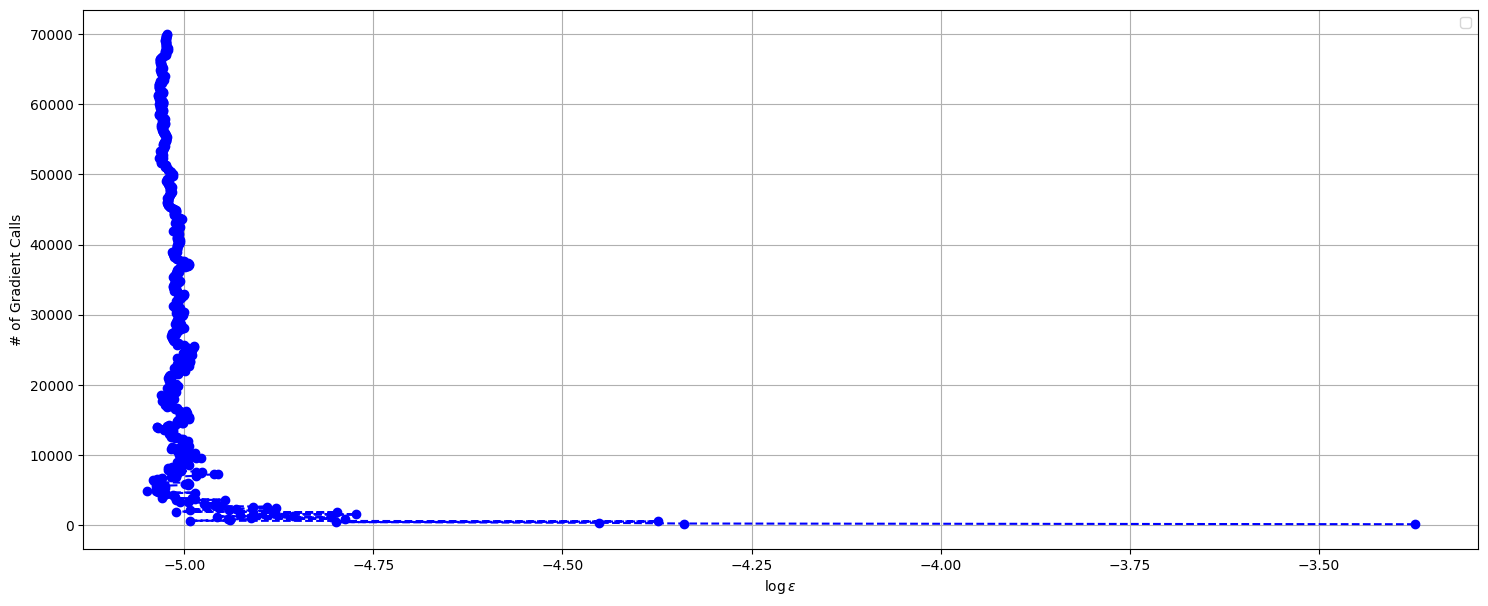

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_err_history)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

In [38]:
# build the model
basis_dim = 9
epoch = 70000
alpha = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.01979517191648488
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.015121467411518145
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.014878228306770373
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.015261024236679126
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.014397867023944903
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.0150644183158875
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.014922425150871325
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.014298349618911792
---------approximate solution path for # epochs = 900 complete-----

In [39]:
# file_path = '/content/drive/MyDrive/Experiments/SGD_results_noisy.csv'
# df = pd.read_csv(file_path)

# df = df.rename(columns={'sup_err': 'sup_err_13'})

# # Add a new column for basis dimension 9
# df['sup_err_9'] = sup_err_history

In [40]:
# build the model
basis_dim = 5
epoch = 70000
alpha = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.037424951791763354
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.03471346944570546
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.03589292615652089
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.03538440912961965
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.034104466438293506
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.03465822339057927
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.03463502228260045
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.0359282642602921
---------approximate solution path for # epochs = 900 complete---------

In [41]:
# # Add a new column for basis dimension 5
# df['sup_err_5'] = sup_err_history

# # Save the updated DataFrame back to the CSV file
# df.to_csv(file_path, index=False)

### Naive Grid Search:

In [34]:
lam_max = 1
lam_min = 0
alpha = 2
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(6, 18, 0.5)
print(delta_list)

tensor([1.5625e-02, 1.1049e-02, 7.8125e-03, 5.5243e-03, 3.9062e-03, 2.7621e-03,
        1.9531e-03, 1.3811e-03, 9.7656e-04, 6.9053e-04, 4.8828e-04, 3.4527e-04,
        2.4414e-04, 1.7263e-04, 1.2207e-04, 8.6317e-05, 6.1035e-05, 4.3158e-05,
        3.0518e-05, 2.1579e-05, 1.5259e-05, 1.0790e-05, 7.6294e-06, 5.3948e-06])


In [35]:
total_itr_list = []
sup_error_list = []
np.random.seed(8675309)
torch.manual_seed(8675309)
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))

    start_time = time.time()
    models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=SGD_data_loader,
                                    data_input_dim=input_dim,
                                    alpha=alpha, SGD=True, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)
    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)
    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)
    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 8.0	 total iteration #: 80	 sup error: 0.0940170586109162	 Execution time: 13.657010078430176 seconds
grid #: 10.0	 total iteration #: 100	 sup error: 0.08418950438499456	 Execution time: 16.944299697875977 seconds
grid #: 11.0	 total iteration #: 110	 sup error: 0.07845392823219305	 Execution time: 18.731600046157837 seconds
grid #: 13.0	 total iteration #: 130	 sup error: 0.07038648426532751	 Execution time: 22.10955238342285 seconds
grid #: 16.0	 total iteration #: 170	 sup error: 0.059329137206077624	 Execution time: 28.9532687664032 seconds
grid #: 19.0	 total iteration #: 220	 sup error: 0.05592554062604909	 Execution time: 37.23021483421326 seconds
grid #: 23.0	 total iteration #: 300	 sup error: 0.04782615602016454	 Execution time: 50.57385468482971 seconds
grid #: 27.0	 total iteration #: 410	 sup error: 0.04410859942436223	 Execution time: 69.2620701789856 seconds
grid #: 32.0	 total iteration #: 720	 sup error: 0.039936110377311755	 Execution time: 121.47914171218872

In [36]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_noisy.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err'])

#     # Write the data from your lists
#     for i in range(len(total_itr_list)):
#         csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

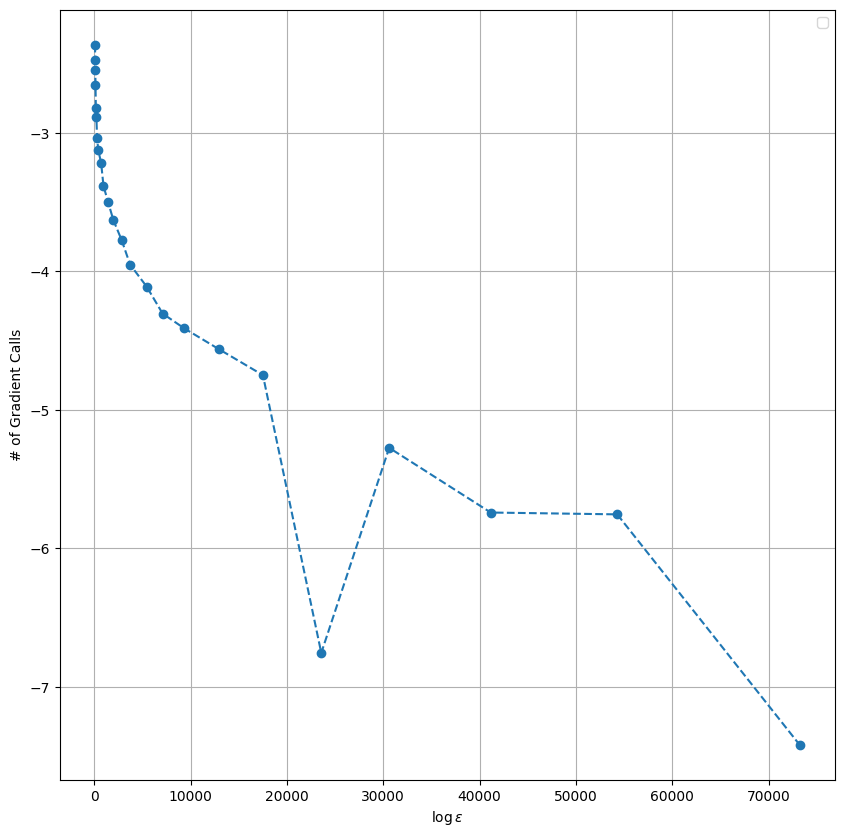

In [38]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_itr_list, np.log(sup_error_list), '--o', )
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the noisy gradient case

In [49]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_noisy.csv'
NGS_results_noisy = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_noisy['num_itr'])
sup_err_NGS = np.array(NGS_results_noisy['sup_err'])

In [50]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_noisy.csv'
SGD_results_noisy = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_noisy['num_itr'])
sup_err_SGD_13 = np.array(SGD_results_noisy['sup_err_13'])
sup_err_SGD_9 = np.array(SGD_results_noisy['sup_err_9'])
sup_err_SGD_5 = np.array(SGD_results_noisy['sup_err_5'])

In [ ]:
# for i in range(len(sup_err_SGD)):
#     sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

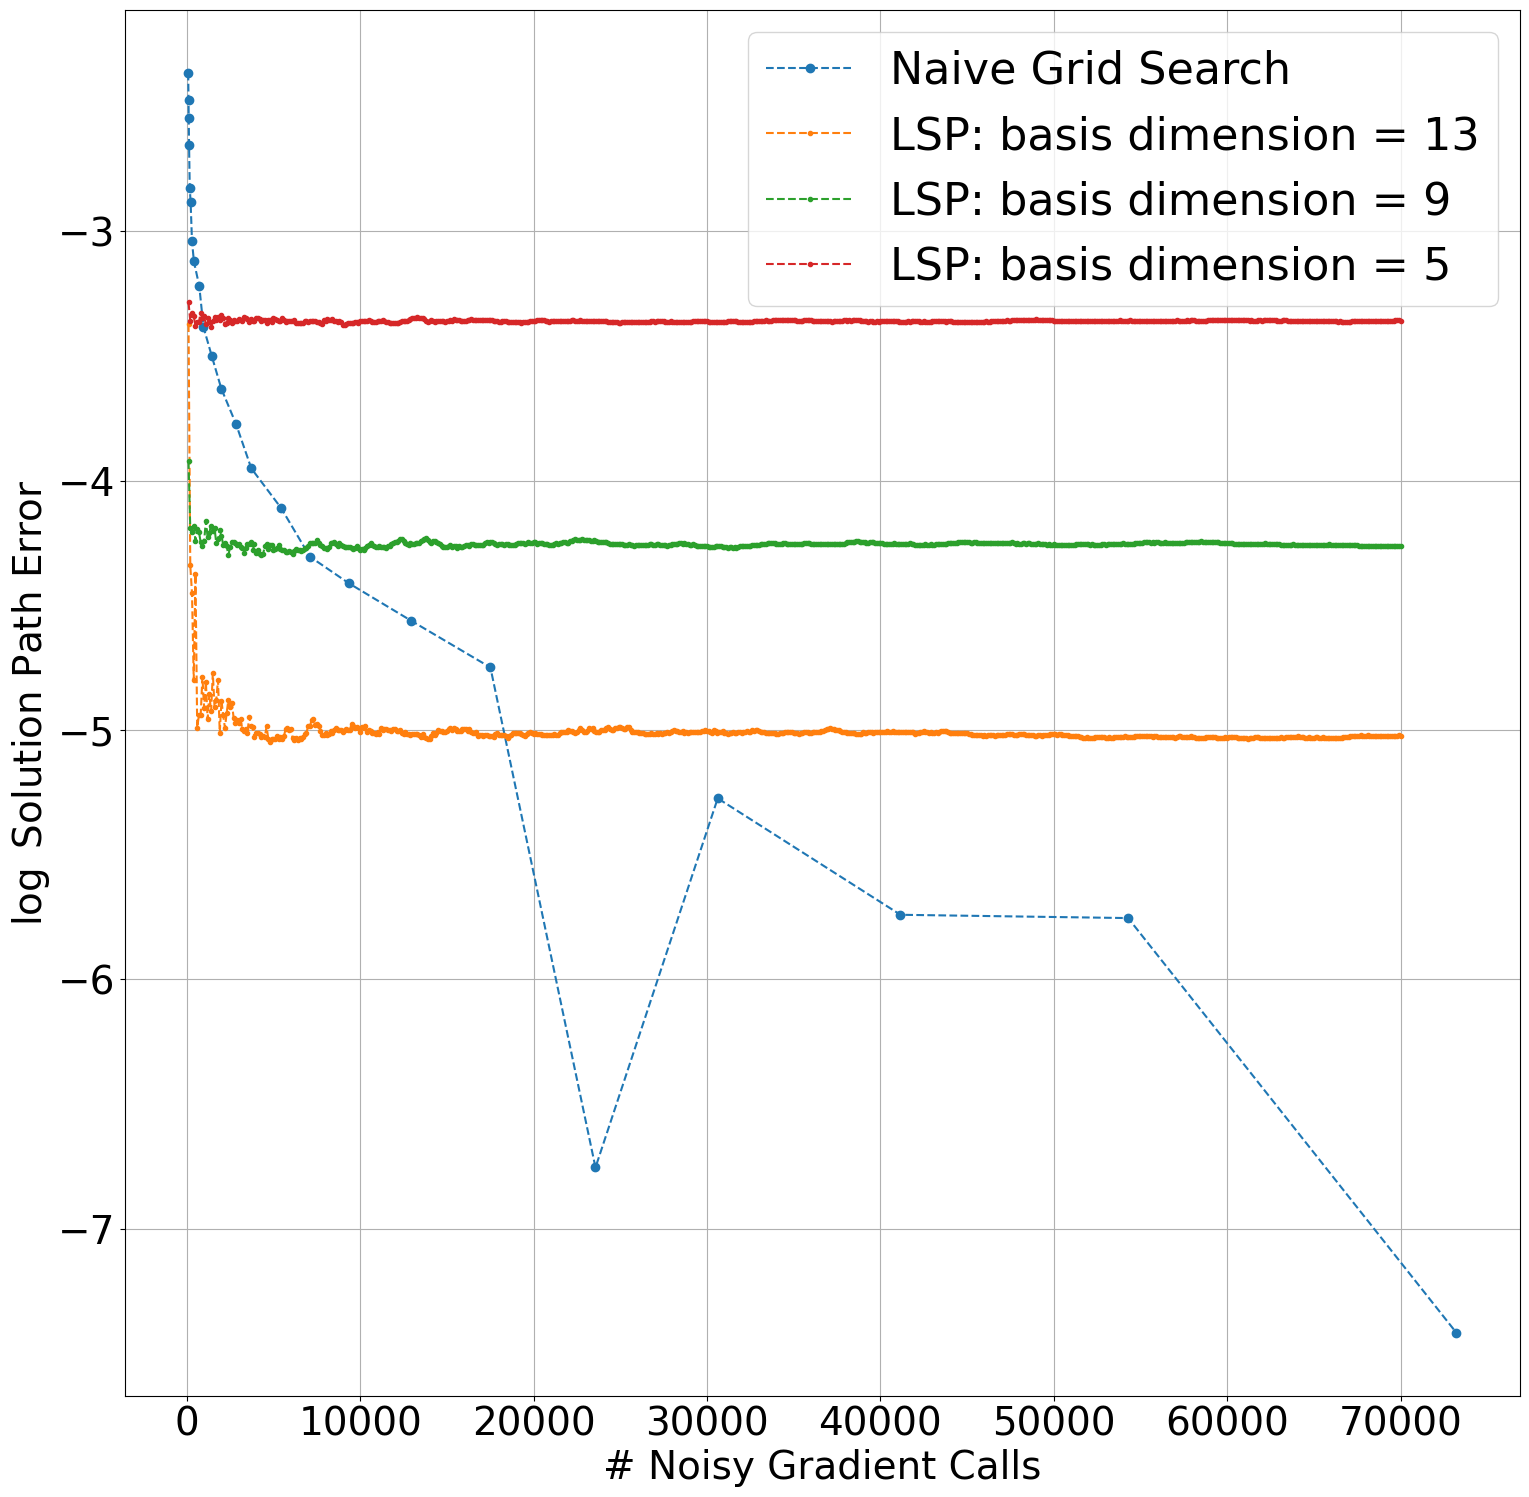

In [51]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(num_itr_NGS, np.log(sup_err_NGS), '--o', label = "Naive Grid Search")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_13), '--.', label = "LSP: basis dimension = 13")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_9), '--.', label = "LSP: basis dimension = 9")
plt.plot(num_itr_SGD, np.log(sup_err_SGD_5), '--.', label = "LSP: basis dimension = 5")

# Set global font size
mpl.rcParams['font.size'] = 32

font_size = 28
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# Noisy Gradient Calls', fontsize=font_size)
plt.ylabel('$\\log$ Solution Path Error', fontsize=font_size)
plt.legend()
plt.grid(True)